In [18]:
import numpy as np
from matplotlib import pyplot as plt
from math import exp, cos, sin, sqrt, atan2


In [19]:
ke = 200
ex = np.zeros(ke)
dx = np.zeros(ke)
sx = np.zeros(ke)
ix = np.zeros(ke)

hy = np.zeros(ke)

ddx = 0.01 # Cell size
dt = ddx / 6e8 # Time step size

number_of_frequencies = 3
freq_in = np.array((50e6, 200e6, 500e6))

t0 = 50
spread = 10

boundary_low = [0, 0]
boundary_high = [0, 0]

# Create Dielectric Profile
epsz = 8.854e-12
epsr = 2
sigma = 0.01
tau = 0.001*1e-6
chi = 2
k_start = 100

gax = np.ones(ke)
gbx = np.zeros(ke)
gcx = np.zeros(ke)

gax[k_start:] = 1 / (epsr + (sigma * dt / epsz)+chi*dt/tau)
gbx[k_start:] = sigma * dt / epsz
gcx[k_start:] = chi*dt/tau

del_exp = exp(-dt/tau)

# To be used in the Fourier transform
arg = 2 * np.pi * freq_in * dt
real_pt = np.zeros((number_of_frequencies, ke))
imag_pt = np.zeros((number_of_frequencies, ke))
real_in = np.zeros(number_of_frequencies)
imag_in = np.zeros(number_of_frequencies)
amp_in = np.zeros(number_of_frequencies)
phase_in = np.zeros(number_of_frequencies)
amp = np.zeros((number_of_frequencies, ke))
phase = np.zeros((number_of_frequencies, ke))

nsteps = 1000

# Dictionary to keep track of desired points for plotting
plotting_points = [
    {
     'num_steps': 250,
     'ex': None,
     'scaling_factor': 1,
     'gb_scaling_factor': 1, 
     'y_ticks': (0, 0.5, 1),
     'y_min': -0.3,
     'y_max': 1.2,
     'y_text_loc': 0.3,
     'label': '(a)', 
     'label_loc': 1.3
    },
    {
     'num_steps': 1000,
     'ex': None,
     'scaling_factor': 1000,
     'gb_scaling_factor': 2, 
     'y_ticks': (-6, -4, -2, 0, 2),
     'y_min': -6.2,
     'y_max': 2.2,
     'y_text_loc': -3,
     'label': '(b)', 
     'label_loc': -1.9
    }
]


In [20]:

# Main FDTD Loop
for time_step in range(1, nsteps + 1):
    # Calculate Dx
    for k in range(1, ke):
        dx[k] = dx[k] + 0.5 * (hy[k - 1] - hy[k])
        
    # Put a sinusoidal at the low end
    pulse = exp(-0.5 * ((t0 - time_step) / spread) ** 2)
    dx[5] = pulse + dx[5]
    
    # Calculate the Ex field from Dx
    for k in range(1, ke):
        ex[k] = gax[k] * (dx[k] - ix[k] - del_exp * sx[k])
        ix[k] = ix[k] + gbx[k] * ex[k]
        sx[k] = del_exp * sx[k] + gcx[k] * ex[k]
        
    # Calculate the Fourier transform of Ex
    for k in range(ke):
        for m in range(number_of_frequencies):
            real_pt[m, k] = real_pt[m, k] + cos(arg[m]* time_step) * ex[k]
            imag_pt[m, k] = imag_pt[m, k] - sin(arg[m]* time_step) * ex[k]
    
    # Fourier Transform of the input pulse
    if time_step < 3 * t0:
        for m in range(number_of_frequencies):
            real_in[m] = real_in[m] + cos(arg[m] * time_step) * ex[10]
            imag_in[m] = imag_in[m] - sin(arg[m] * time_step) * ex[10]
            
    # Absorbing Boundary Conditions
    ex[0] = boundary_low.pop(0)
    boundary_low.append(ex[1])
    
    ex[ke - 1] = boundary_high.pop(0)
    boundary_high.append(ex[ke - 2])
    
    # Calculate the Hy field
    for k in range(ke - 1):
        hy[k] = hy[k] + 0.5 * (ex[k] - ex[k + 1])
        
    # Save data at certain points for later plotting
    for plotting_point in plotting_points:
        if time_step == plotting_point['num_steps']:
            plotting_point['ex'] = np.copy(ex)
        

In [21]:
    
# Calculate the amplitude and phase at each frequency
for m in range(number_of_frequencies):
    amp_in[m] = sqrt(imag_in[m] ** 2  + real_in[m] **2)
    phase_in[m] = atan2(imag_in[m], real_in[m])

    for k in range(ke):
        amp[m, k] = (1 / amp_in[m]) * sqrt((real_pt[m,k]) ** 2 + (imag_pt[m, k]) ** 2)
        phase[m, k] = atan2(imag_pt[m, k], real_pt[m, k]) - phase_in[m]

In [ ]:
def plot_e_field(data,
                 gb,
                 timestep,
                 scaling_factor,
                 gb_scaling_factor,
                 y_ticks,
                 y_min,
                 y_max,
                 y_text_loc,
                 label,
                 label_loc
                 ):
    """Plot of E field at a single time step"""
    
    plt.plot(data*scaling_factor, color='k', linewidth=1)
    plt.ylabel('E$_x$ (V/m)', fontsize='12')
    plt.xticks(np.arange(0, 199, step=20))
    plt.xlim(0, 199)
    plt.yticks(y_ticks)
    plt.ylim(y_min, y_max)
    plt.text(150, y_text_loc, 'Time Domain, T = {}'.format(timestep), horizontalalignment='center')
    plt.plot(gb * gb_scaling_factor / gb[120], 'k--', linewidth=0.75) # The math on gb is just for scaling
    plt.text(-25, label_loc, label, horizontalalignment='center')
    return

def plot_amp(data, gb, freq, label, x_label):
    """ Plot of amplitude at one frequency"""
    plt.plot(data, color='k', linewidth=1)
    plt.ylabel('Amp')
    plt.xticks(np.arange(0, 199, step=20))
    plt.xlim(0, 199)
    plt.yticks(np.arange(0, 2.1, step=1))
    plt.ylim(-0.2, 2.0)
    plt.text(150, 1.2,
                'Freq. Domain at {} MHz'.format(int(round
                (freq / 1e6))),
                horizontalalignment='center')
    plt.plot(gb*1/gb[120], 'k--',
            linewidth=0.75) # The math on gb is just for scaling
    plt.text(-25, 0.6, label, horizontalalignment='center')
    plt.xlabel(x_label)
    return


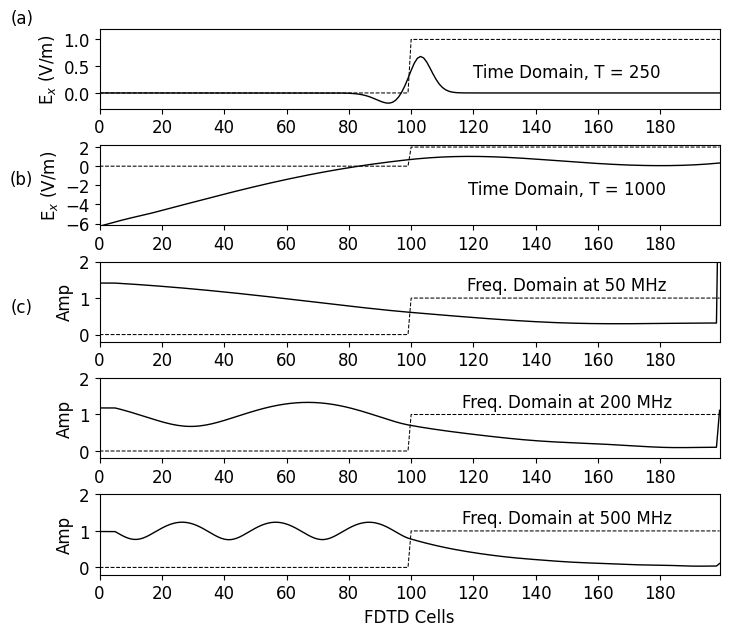

(None,)

In [23]:
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(8, 7))

# Plot the E field at each of the time steps saved earlier
for subplot_num, plotting_point in enumerate(plotting_points):
    ax = fig.add_subplot(5, 1, subplot_num + 1)
    plot_e_field(
        plotting_point['ex'],
        gbx,
        plotting_point['num_steps'],
        plotting_point['scaling_factor'],
        plotting_point['gb_scaling_factor'],
        plotting_point['y_ticks'],
        plotting_point['y_min'],
        plotting_point['y_max'],
        plotting_point['y_text_loc'],
        plotting_point['label'],
        plotting_point['label_loc']
    )

# Dictionary to keep track of plotting for the amplitude
plotting_freqs = [
    {'freq': freq_in[0],
        'amp': amp[0],
        'label': '(c)',
        'x_label':''
        },
    {'freq': freq_in[1],
        'amp': amp[1],
        'label': '',
        'x_label':''
    },
    {'freq': freq_in[2],
        'amp': amp[2],
        'label': '',
        'x_label':'FDTD Cells'
    }
]

# Plot the amplitude at each of the frequecies of interest 
for subplot_num, plotting_freq in enumerate(plotting_freqs):
    ax = fig.add_subplot(5, 1, subplot_num + 3)
    plot_amp(
        plotting_freq['amp'],
        gbx,
        plotting_freq['freq'],
        plotting_freq['label'],
        plotting_freq['x_label'])

plt.subplots_adjust(bottom=0.1, hspace=0.45)
plt.show(),